This notebooks uses the following dataset <br>
https://archive.ics.uci.edu/ml/datasets/Motion+Capture+Hand+Postures

# 1. Analysis of the Problem

## Understand the problem

working hypothesis
think about model architecture
loss function
and loss criteria

select a measure of success
    Detect all classes/types of hand gestures with a high accuracy
    Classification Problem
    Check whether class-imbalanced problems

Dataset with class of the hand gesture/'Class' (our target value) the person which performed the hand gesture ('User') and a 
feature vector that consists 11 subvectors. Each subvector contains X, Y and Z coordinates. Those coordinates belong to one of the detected markes on the hand glove the user is wearing

* motion capture camera records 12 users performing 5 hand postures with markers attached to a left-handed glove
* rigid pattern of markers on the back of the glove -> establish local coordinate system for the hand
* 11 markers were attached to the thumb and fingers of the glove
* there is no a priori correspondence between the markers of two given records
* due to the resolution of the capture volume and self-occlusion due to the orientation and configuration of the hand and fingers, many records have missing markers.
    -> the number of visible markers in a record varied considerably.


The Problem:
We cannot easily apply traditional approaches because of two properties of point clouds:
* unordered collection (Point 1 with X,Y and Z coordinates could refer to the thh )
* the size of the point cloud varies (due to occlusion, etc.)

## Useful Information from the authors/paper

Class label:<br>
1=Fist(with thumb out), 2=Stop(hand flat), 3=Point1(point with pointer finger), 4=Point2(point with pointer and middle fingers), 5=Grab(fingers curled as if to grab)


Preprocessing:<br>
all markers were transformed to the local coordinate system of the record containing them.

Reduce number of records:<br>
each transformed marker with a norm greater than 200 millimeters was pruned. 
records that contained fewer than 3 markers was removed. 
the data has at most 12 markers per record and at least 3

Be careful:<br>
It is likely that for a given record and user there exists a near duplicate record originating from the same user.
-> evaluate on leave-one-user-out basis wherein

## Ideas I want to try out


**My goal**

* able to predict which gesture a person is performing

* achieve a high accuracy

**My idea/approach**

* 1.approach: extract features that are meaningful for a given data point, train conventional models

* 2.approach: use models that are adapted to point clouds and have been developed specifically for this data

# 2. Data Exploration and Preparation

Check for missing values, NaN values or features,
uniqueness of the data (is it as it was expected to be)
understand the variations in the data (statistical tools)
outliers?
Is it possible to combine features?
Do you have unnecessary features? (a column which gives no information – for instance name
column– or a feature you consider unrelated to the problem)
Check the correlation matrix. It will tell you how much the features are related. You may say,
for instance, there is a great potential to reduce number of dimensions.
scale data (for example, in the [-1, 1] range).

## Preparing the enviroment

In [1]:
#%reload_ext autoreload
#%autoreload 2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 50
import time
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from typing import Tuple
#from sklearn.decomposition import PCA
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# My custom functions
from scripts import analyze_helper, visualisation

# Utility functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, average_precision_score, recall_score
from sklearn import preprocessing as pp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.utils import to_categorical

# Models we want to use
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

2023-03-04 12:06:52.418891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 12:06:52.553916: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/josh/Documents/seam_eng/group4_ws/devel/lib:/opt/ros/noetic/lib
2023-03-04 12:06:52.553940: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-04 12:06:53.287384: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; d

## Write utility functions I want to use multiple times

In [2]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred):

    plt.clf()

    class_labels = ['Fist', 'Stop', 'Point1', 'Point2', 'Grab']
    cf_matrix = confusion_matrix(y_true, y_pred, labels=[1, 2, 3, 4, 5])
    
    group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
    #normalize
    cf_matrix = (cf_matrix.T/cf_matrix.sum(axis=1)).T
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(5,5)

    custom_cmap = sns.light_palette("#009682", as_cmap=True)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=custom_cmap, xticklabels=class_labels, yticklabels=class_labels, cbar=False)
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

In [3]:
class Report:

    report: dict

    def __init__(self, model, X_test, y_test, description:list=[]):
        self.X_test = X_test
        self.y_test = y_test
        self.description = description

        self.report = self.create_report(model)


    def create_report(self, model):

        try:
            y_score = model.predict_proba(self.X_test)
        except AttributeError:
            print('No report possible, because no predict_proba method')
            report = None
            return
        y_score_2 = model.predict(self.X_test)
        report = classification_report(self.y_test, y_score_2, output_dict=True)

        return report


    def __str__(self):

        if self.report is None:
            print('No return possbile')
            return

        pattern = '''
        ***********************REPORT*******************************
        Average (macro) precision: {}
        Average accuracy: {}
        Average (macro) recall: {}
        Description {}
        ************************************************************
        '''
        return pattern.format(round(self.report["macro avg"]["precision"],5), round(self.report["accuracy"],6), round(self.report["macro avg"]["recall"],6), ', '.join(self.description))

## Loading the Data

In [4]:
file_path_raw = os.path.join('data', 'Postures.csv')
df_raw = pd.read_csv(file_path_raw, sep=',', na_values='?')

## Understand the Data

### Choose a metric

To choose a metric we have to check whether the classes are balenced/unbalanced

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


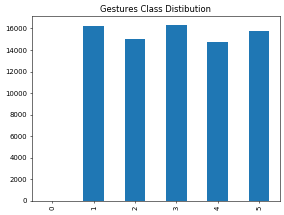

In [5]:
class_counts = df_raw['Class'].value_counts(sort=False)
class_counts.plot(kind='bar', title='Gestures Class Distibution')
plt.show()

To jugde the model perfomance we will choose a mixture of multiple metrics:
* Confusion Matrix
* Accuracy (we have balanced classes!)
* Recall (made TP predictions divided by possible TP predictions)
* precission-recall plot

TODO 
Maybe Later
* ROC AUC (Receiver Operator Characteristic — Area Under the Curve, we want a high TPR with a low FPR)
Note: we will use the One vs Rest strategy for ROC AUC (because it is usally a metric for binary classification)

Write utility function to use the ROC AUC for multiclass classficiation

In [6]:
def precision_recall_multiclass(model, X_test, y_test):

    plt.clf()

    y_score = model.predict_proba(X_test)
    y_score_2 = model.predict(X_test)
    
    #print('Amount and Distribution of Test Data: \n', y_test.value_counts())
    y_bin = pp.label_binarize(y_test, classes=model.classes_)

    precision = dict()
    recall = dict()
    average_precision = dict()
    classes = model.classes_

    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])
        #print('\n average precision: ', classes[i], ': ', average_precision[i])
        try:
            plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(classes[i]))
        except Exception as e:
            print(e)

    
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()

# TODO write evaluation function with accuracy etc. as a report

## Data Exploration

In [7]:
df_raw.columns

Index(['Class', 'User', 'X0', 'Y0', 'Z0', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2',
       'X3', 'Y3', 'Z3', 'X4', 'Y4', 'Z4', 'X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6',
       'X7', 'Y7', 'Z7', 'X8', 'Y8', 'Z8', 'X9', 'Y9', 'Z9', 'X10', 'Y10',
       'Z10', 'X11', 'Y11', 'Z11'],
      dtype='object')

In [8]:
# Check which columns have missing values
print(f"Missing values in: {analyze_helper.check_for_missing_vals(df_raw)}")
# Compute missing ratio, hide columns with no missing values (0.0%)
analyze_helper.compute_missing_ratio(df_raw)

Missing values in: ['X3', 'Y3', 'Z3', 'X4', 'Y4', 'Z4', 'X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6', 'X7', 'Y7', 'Z7', 'X8', 'Y8', 'Z8', 'X9', 'Y9', 'Z9', 'X10', 'Y10', 'Z10', 'X11', 'Y11', 'Z11']


X3      0.88
Y3      0.88
Z3      0.88
X4      4.00
Y4      4.00
Z4      4.00
X5     16.68
Y5     16.68
Z5     16.68
X6     33.10
Y6     33.10
Z6     33.10
X7     50.13
Y7     50.13
Z7     50.13
X8     60.86
Y8     60.86
Z8     60.86
X9     69.31
Y9     69.31
Z9     69.31
X10    81.11
Y10    81.11
Z10    81.11
X11    99.96
Y11    99.96
Z11    99.96
Name: percent_missing, dtype: float64

Hint 1 for preprocessing:
drop the coordinates (X,Y,Z) for point 10 and 11

In [9]:
df_raw = df_raw.fillna(0)

In [10]:
df_raw.head(5)
df_raw.drop([0], inplace=True)
df_raw.reset_index(drop=True, inplace=True)

In [11]:
print('Number of Instances  : ', df_raw.shape[0])
print('Number of Attributes : ', df_raw.shape[1])
print('Number of target classes   : ', df_raw['Class'].nunique()-1)
print('Number of users   : ', df_raw['User'].nunique())

Number of Instances  :  78095
Number of Attributes :  38
Number of target classes   :  4
Number of users   :  14


The description says the data set contains 12 User. No information provided (why are 14 user in the data?).
Hint for us to drop User 4 and 7 ?
They both have signifiantly less data points

In [12]:
user_group = df_raw.groupby(['User'], sort=False)
user_group.count()

,Class,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
User,,,,,,,,,,,,,,,,,,,,,
0,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,...,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048
1,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,...,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717
2,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,...,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513
4,379,379,379,379,379,379,379,379,379,379,...,379,379,379,379,379,379,379,379,379,379
5,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,...,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105
6,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,...,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377
7,492,492,492,492,492,492,492,492,492,492,...,492,492,492,492,492,492,492,492,492,492
8,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,...,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811
9,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,...,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920


In [13]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78095 entries, 0 to 78094
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Class   78095 non-null  int64  
 1   User    78095 non-null  int64  
 2   X0      78095 non-null  float64
 3   Y0      78095 non-null  float64
 4   Z0      78095 non-null  float64
 5   X1      78095 non-null  float64
 6   Y1      78095 non-null  float64
 7   Z1      78095 non-null  float64
 8   X2      78095 non-null  float64
 9   Y2      78095 non-null  float64
 10  Z2      78095 non-null  float64
 11  X3      78095 non-null  float64
 12  Y3      78095 non-null  float64
 13  Z3      78095 non-null  float64
 14  X4      78095 non-null  float64
 15  Y4      78095 non-null  float64
 16  Z4      78095 non-null  float64
 17  X5      78095 non-null  float64
 18  Y5      78095 non-null  float64
 19  Z5      78095 non-null  float64
 20  X6      78095 non-null  float64
 21  Y6      78095 non-null  float64
 22

### Data Visualization

In [14]:
def pltHand(handPoints):
    plt.close('all')
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    for i in range(11):
        pntx = f'X{i}'
        pnty = f'Y{i}'
        pntz = f'Z{i}'
        
        if(handPoints[pntx].values[0] == 0 or
            handPoints[pnty].values[0] == 0 or
            handPoints[pntz].values[0] == 0):
            n = 0;
        else:
            xlocation = handPoints[pntx]
            ylocation = handPoints[pnty]
            zlocation = handPoints[pntz]
            ax.scatter(xlocation, ylocation, zlocation, marker='v')
    
    crntClass = handPoints['Class'].values[0]
    if (crntClass == 1):
        title = 'Fist + Thumb out'
    if(crntClass == 2):
        title = 'Stop/Flat hand'
    if (crntClass == 3):
        title = 'Point with pointer finger'
    if (crntClass == 4):
        title = 'Point with pointer + middle finger'
    if (crntClass == 5):
        title = 'Grab'
    
    plt.title(title)
    plt.show()


In [15]:
#TODO create a rotateable 3D plot

In [16]:
# Plot a random hand gesture from the dataset to get a an idea of the data
#TODO not working on linux, check why
'''
for _ in range(4):
    rand_dp = np.random.randint(df_raw.shape[0], size=1)[0]
    pltHand(df_raw[rand_dp:rand_dp+1] )
'''

'\nfor _ in range(4):\n    rand_dp = np.random.randint(df_raw.shape[0], size=1)[0]\n    pltHand(df_raw[rand_dp:rand_dp+1] )\n'

In [17]:
def correlation_matrix(df: pd.DataFrame):

    correlationMatrix = pd.DataFrame(df_raw).corr() 
    f = plt.figure(figsize=(12, 6))
    plt.matshow(correlationMatrix, fignum=f.number)
    plt.xticks(range(df_raw.shape[1]), df_raw.columns, fontsize=14, rotation=75)
    plt.yticks(range(df_raw.shape[1]), df_raw.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


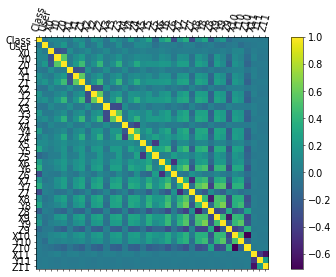

In [18]:
correlation_matrix(df_raw)

## Pre-processing



### General

In [19]:
# Drop rows of user 4 and 7
# Because they have significantly less data points
df_raw = df_raw[df_raw['User'] != 4]
df_raw = df_raw[df_raw['User'] != 7]
df_raw.reset_index(drop=True, inplace=True)

In [20]:
# Drop coordinates of point 10 and 11
# More than 90% of the data is missing
# Search for "Hint 1" for further information
df_raw.drop(['X10', 'Y10', 'Z10', 'X11', 'Y11', 'Z11'], inplace=True, axis=1)

### PCA

In [21]:
# TODO compute PCA and plot the data

### Preparing Dataset

### a. Extract features (min, max, mean, etc.) - df_aggregate

Ideas for new features: (inspired from paper)<br>
* number of markers
* mean (per coordinate)
* Eigenvalues and vectors of the points covariance matrix
https://math.stackexchange.com/questions/2842830/why-does-the-eigen-decomposition-of-the-covariance-matrix-of-a-point-cloud-give
* dimensions of the axis-aligned minimum bounding box centered on the mean

Keep in mind that each feature has to aggregate the points in such a way that the result is order invariant!


In [22]:
# New data set we want to fill step by step
df_aggregate= pd.DataFrame()
# We dont want to change the original data set
df_raw_dummy = df_raw.copy(deep=True)

# Save the user and class column
df_user = df_raw_dummy.pop('User')
df_class = df_raw_dummy.pop('Class')


In [23]:
# Extract the X, Y and Z columns
df_x = df_raw_dummy[df_raw_dummy.columns[pd.Series(df_raw_dummy.columns).str.startswith('X')]]
df_y = df_raw_dummy[df_raw_dummy.columns[pd.Series(df_raw_dummy.columns).str.startswith('Y')]]
df_z = df_raw_dummy[df_raw_dummy.columns[pd.Series(df_raw_dummy.columns).str.startswith('Z')]]

In [24]:
# Extract the mean of the X, Y and Z columns
for coordinate in ['X', 'Y', 'Z']:
    df_aggregate[f'{coordinate}_mean'] = df_raw_dummy[df_raw_dummy.columns[pd.Series(df_raw_dummy.columns).str.startswith(coordinate)]].mean(axis=1)

In [25]:
# Extract the number of visible points (not occluded)
df_aggregate['n_points'] = (df_raw_dummy.astype(bool).sum(axis=1))/3
df_aggregate

,X_mean,Y_mean,Z_mean,n_points
0,31.220158,27.403799,-33.548944,5.0
1,32.392560,27.823996,-32.104566,5.0
2,32.081207,27.936918,-32.385520,5.0
3,31.719552,27.575915,-32.964177,5.0
4,31.594851,27.416170,-33.195235,5.0
...,...,...,...,...
77219,27.823671,97.288106,-29.054040,10.0
77220,28.021968,97.191781,-29.248339,10.0
77221,28.103645,96.953570,-29.735080,10.0
77222,20.384035,93.649845,-25.356364,9.0


In [26]:
df_raw_dummy

,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,...,Z6,X7,Y7,Z7,X8,Y8,Z8,X9,Y9,Z9
0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,-52.919272,85.232264,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,-69.982489,87.450873,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,-70.658489,86.835388,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,-72.228461,61.596157,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,-72.574743,86.368748,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77219,54.251127,129.177414,-44.252511,27.720784,107.810661,11.099282,-1.270139,122.758679,-46.460186,-1.901940,...,-17.150292,-22.833830,104.593913,-53.126136,61.494952,101.205748,-6.543115,87.733364,61.216363,-62.126278
77220,54.334883,129.253842,-44.016320,27.767911,107.914808,11.069842,-30.334054,77.858214,-17.002723,-22.743924,...,4.248334,61.390015,101.468284,-5.985371,88.177233,60.780642,-62.130563,78.229847,33.078407,-45.249543
77221,54.151540,129.269502,-44.173273,27.725978,108.034006,11.020347,-22.574718,104.222208,-53.939140,-30.225675,...,-46.796054,88.291029,60.362768,-62.718735,-1.779495,98.089459,3.835904,78.591554,32.327738,-46.166556
77222,27.915311,108.007390,10.814957,-0.910435,122.464093,-47.271248,-30.084588,77.705861,-17.460853,26.715915,...,-43.967820,-1.581415,98.017411,3.394291,88.465709,60.050791,-63.221626,0.000000,0.000000,0.000000


My idea:<br>
find the orientation of a given cluster<br>
(https://math.stackexchange.com/questions/2842830/why-does-the-eigen-decomposition-of-the-covariance-matrix-of-a-point-cloud-give)

1. Rearange the dataset (1 point per row with X, Y, Z value)
-> All points per row will be saved in a batch as new sub dataframe
2. Compute the covariance matrix for each sub dataframe
3. Calculate the Eigenvalues and Eigenvectors of the covariance matrix
4. Concat created features to the dataframe


DISCLAIMER: <br>
The following function can take up to 1 min!

In [27]:

# Assume you have a DataFrame called 'df' with the columns ['X0', 'Y0', 'Z0', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']
# Reorganize the dataframe to have each row as a batch of data
# 'X0', 'Y0', 'Z0',
# 'X1', 'Y1', 'Z1',
# 'X2', 'Y2', 'Z2'

# Create an empty list to store the batches of data
batches = []

# Iterate over the DataFrame and extract the batches of data
for row in range(0, df_raw_dummy.shape[0]):

    col_batch = []
    # Extract a batch of data for the current row
    for col in range(0, df_raw_dummy.shape[1], 3):
        batch = df_raw_dummy.iloc[row, col:col+3]
        # Rename the columns
        batch.index = ['X', 'Y', 'Z']
        #print(f'batch: {batch}')
        col_batch.append(batch)
    # Append the batch to the list
    batches.append(col_batch)

# Concatenate the batches of data under each other
concat_batches = []
for batch in batches:
    concat_batch = pd.concat(batch, axis=1).transpose()
    concat_batches.append(concat_batch)
    # Remove rows with all zeros
    concat_batch = concat_batch[(concat_batch.T != 0).any()]

# Create a dictionary with the eigenvalues and eigenvectors as values
eigen_dict = {'eigenvec_1_1': [],
                'eigenvec_1_2': [],
                'eigenvec_1_3': [],
                'eigenvec_2_1': [],
                'eigenvec_2_2': [],
                'eigenvec_2_3': [],
                'eigenvec_3_1': [],
                'eigenvec_3_2': [],
                'eigenvec_3_3': [],
              'eigenval_1': [],
              'eigenval_2': [],
              'eigenval_3': []}

# Create the DataFrame
eigen_df = pd.DataFrame(eigen_dict)

# Compute the covariance matrix for each batch
for concat_batch in concat_batches:
    # Compute the covariance matrix
    cov_matrix = np.cov(concat_batch, rowvar=False)
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Add the eigenvalues and eigenvectors to the DataFrame
    # Store eigenvector 1
    eigen_dict['eigenvec_1_1'].append(eigenvectors[0, 0])
    eigen_dict['eigenvec_1_2'].append(eigenvectors[1, 0])
    eigen_dict['eigenvec_1_3'].append(eigenvectors[2, 0])
    # Store eigenvector 2
    eigen_dict['eigenvec_2_1'].append(eigenvectors[0, 1])
    eigen_dict['eigenvec_2_2'].append(eigenvectors[1, 1])
    eigen_dict['eigenvec_2_3'].append(eigenvectors[2, 1])
    # Store eigenvector 3
    eigen_dict['eigenvec_3_1'].append(eigenvectors[0, 2])
    eigen_dict['eigenvec_3_2'].append(eigenvectors[1, 2])
    eigen_dict['eigenvec_3_3'].append(eigenvectors[2, 2])
    # Store eigenvalues
    eigen_dict['eigenval_1'].append(eigenvalues[0])
    eigen_dict['eigenval_2'].append(eigenvalues[1])
    eigen_dict['eigenval_3'].append(eigenvalues[2])

# Finally add generated features to the DataFrame
df_aggregate = pd.concat([df_aggregate, pd.DataFrame(eigen_dict)], axis=1)

In [28]:
batches[0][0].to_numpy()
shape = (len(batches), 3)
print(shape)
X_set = np.ndarray(shape = shape)
for batch in batches:
    for col in batch:
        np.append(X_set ,col.to_numpy())

#TODO not used rigth now


(77224, 3)


In [29]:
df_aggregate
#TODO remove header from second df

,X_mean,Y_mean,Z_mean,n_points,eigenvec_1_1,eigenvec_1_2,eigenvec_1_3,eigenvec_2_1,eigenvec_2_2,eigenvec_2_3,eigenvec_3_1,eigenvec_3_2,eigenvec_3_3,eigenval_1,eigenval_2,eigenval_3
0,31.220158,27.403799,-33.548944,5.0,-0.592168,-0.526425,0.610093,-0.679408,-0.080937,-0.729283,-0.433292,0.846361,0.309729,3303.459708,31.125729,393.299191
1,32.392560,27.823996,-32.104566,5.0,-0.612694,-0.533061,0.583483,-0.660054,-0.060910,-0.748745,-0.434667,0.843882,0.314529,3308.347956,26.851403,393.193165
2,32.081207,27.936918,-32.385520,5.0,-0.606186,-0.535279,0.588231,-0.658320,-0.077302,-0.748758,-0.446266,0.841131,0.305525,3313.095350,27.067267,395.055695
3,31.719552,27.575915,-32.964177,5.0,-0.600247,-0.529105,0.599793,-0.655695,-0.103896,-0.747843,-0.458004,0.842172,0.284569,3306.145497,27.729013,393.524673
4,31.594851,27.416170,-33.195235,5.0,-0.598431,-0.526505,0.603881,-0.657469,-0.108005,-0.745701,-0.457837,0.843284,0.281527,3304.675159,29.444009,393.498111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77219,27.823671,97.288106,-29.054040,10.0,0.875153,-0.440633,-0.199875,-0.449442,-0.893308,0.001453,0.179191,-0.088561,0.979820,2029.730672,761.522468,584.641706
77220,28.021968,97.191781,-29.248339,10.0,0.869813,-0.446504,-0.209904,-0.461688,-0.886626,-0.027154,0.173982,-0.120529,0.977345,2064.006800,762.311322,588.108972
77221,28.103645,96.953570,-29.735080,10.0,0.865906,-0.452405,-0.213392,-0.472325,-0.879944,-0.051069,0.164669,-0.145012,0.975631,2074.594214,767.103862,592.169837
77222,20.384035,93.649845,-25.356364,9.0,0.213676,0.226960,0.950174,-0.815051,0.577614,0.045320,0.538548,0.784124,-0.308407,591.537322,1397.531289,1796.343364


In [30]:
# Add user and class information to the new data set after the feature extraction
df_aggregate['User'] = df_user
df_aggregate['Class'] = df_class

**Evaluation Strategy**:<br>
We will use a k-Fold cross-validation to evaluate our model <br>
We randomly choose 2 User for the test set <br>
Then we remove the users from the selectable list so that each user is in the test data set at most once over all k runs <br>
For the next split we again choose 2 random User, and so on<br>

In [31]:
import random

def get_train_test_user(df:pd.DataFrame, user_list:list, num_user_test:int=2):
    '''This function returns the indices for the training and test set.
    The function randomly selects two users for the test set and the remaining
    users for the training set.
    
    return: train_indices, test_indices'''

    # Create a list of indices for the training and test set
    train_indices = []
    test_indices = []
    
    # Generate 2 random numbers between 0 and 14
    test_user_1, test_user_2 = random.sample(user_list, num_user_test)
    print(f'User picked for test set: {test_user_1}, {test_user_2}')
    

    # Iterate over the users
    for user in user_list:
        # Get the indices for the current user
        indices = df[df['User'] == user].index
        # Append the indices to the list
        if user == test_user_1 or user == test_user_2:
            test_indices.extend(indices)
        else:
            train_indices.extend(indices)
    
    # Remove the test users from the user list so they cannot be selected again
    user_list = [x for x in user_list if x != test_user_1 and x != test_user_2]

    return train_indices, test_indices, user_list

def custom_cv_approach(df:pd.DataFrame, user_list:list, num_user_test:int=2):
    '''
    each user is iteratively left out from training and used as a test set. 
    We then tests the generalization of the algorithm to new users. 
    A 'User' attribute is provided to accomodate this strategy. 
    '''
    
    # Get the indices for the training and test set
    train_indices, test_indices, user_list = get_train_test_user(df, user_list, num_user_test)
    print(f'train_indices examples: {len(train_indices)}')
    print(f'test_indices examples: {len(test_indices)}')
    # Create the training and test set
    X_train = df.iloc[train_indices, :]
    y_train = X_train.pop('Class')
    X_test = df.iloc[test_indices, :]
    y_test = X_test.pop('Class')

    return X_train, y_train, X_test, y_test, user_list



In [32]:
user_group = df_aggregate.groupby(['User'], sort=False)
user_group.count()

,X_mean,Y_mean,Z_mean,n_points,eigenvec_1_1,eigenvec_1_2,eigenvec_1_3,eigenvec_2_1,eigenvec_2_2,eigenvec_2_3,eigenvec_3_1,eigenvec_3_2,eigenvec_3_3,eigenval_1,eigenval_2,eigenval_3,Class
User,,,,,,,,,,,,,,,,,
0,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048
1,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717
2,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513
5,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105
6,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377
8,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811
9,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920
10,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573
11,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061


In [33]:
#TODO add augmentation to the data set.
# e.g. add Jitter or Shuffle data

### c.I Split data - Wrong way

#### Demonstration data set (WRONG WAY) - mixed user

******************************************************
DEMONSTRATION: this shows how NOT to do it:<br>
Splitting the naive way (similar data points will be in both sets)
******************************************************

In [34]:
df_raw

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z6,X7,Y7,Z7,X8,Y8,Z8,X9,Y9,Z9
0,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1,0,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77219,5,14,54.251127,129.177414,-44.252511,27.720784,107.810661,11.099282,-1.270139,122.758679,...,-17.150292,-22.833830,104.593913,-53.126136,61.494952,101.205748,-6.543115,87.733364,61.216363,-62.126278
77220,5,14,54.334883,129.253842,-44.016320,27.767911,107.914808,11.069842,-30.334054,77.858214,...,4.248334,61.390015,101.468284,-5.985371,88.177233,60.780642,-62.130563,78.229847,33.078407,-45.249543
77221,5,14,54.151540,129.269502,-44.173273,27.725978,108.034006,11.020347,-22.574718,104.222208,...,-46.796054,88.291029,60.362768,-62.718735,-1.779495,98.089459,3.835904,78.591554,32.327738,-46.166556
77222,5,14,27.915311,108.007390,10.814957,-0.910435,122.464093,-47.271248,-30.084588,77.705861,...,-43.967820,-1.581415,98.017411,3.394291,88.465709,60.050791,-63.221626,0.000000,0.000000,0.000000


In [35]:

# Split the data into train and test set
X_train_mixed, X_test_mixed, y_train_mixed, y_test_mixed = train_test_split(df_raw, df_raw['Class'], test_size=0.25)
user_group = df_raw.groupby(['User'], sort=False)

We normalize the data using a Min-Max-Scaler

In [36]:
# Normalize the data with MinMaxScaler

# Create the scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(X_train_mixed)

# Transform the training and test data
X_train_mixed = scaler.transform(X_train_mixed)
X_test_mixed = scaler.transform(X_test_mixed)

#### c.II Split data properly (but still on raw data set)


We now have a CV loop:
I split the data in the same loop, where I train the model for a specific k-fold <br>
Therefore I dont split the data beforehand in this section

# 1. Testing Phase I: Baseline Models

## Random Forest Classifier

In [37]:
# Hyperparameters:
#You need to check model descriptions for the hyperparameters. 
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier
#-----------------------------------------------------------------
# Number of trees in the forest:
n_estimators = 10
# Number of features to consider when looking for the best split:
max_features = 'auto'
# Maximum depth of the tree:
max_depth = None
# Minimum number of samples required to split an internal node:
min_samples_split = 2
# Minimum number of samples required to be at a leaf node:
min_samples_leaf = 1
# Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. 
max_leaf_nodes = None
# Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree:
bootstrap = False
# Whether to use out-of-bag samples to estimate the generalization score. Only available if bootstrap=True.
oob_score = False
# Number of jobs to run in parallel. (-1) means use all.
n_jobs = -1
# Random state
random_state = 2023
#-----------------------------------------------------------------
# Creating the classifier:
RFC = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                              max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap,oob_score=oob_score, n_jobs=n_jobs, random_state=random_state)



In [38]:
#TODO plot feature importance
'''
feature_importance = np.array(RFC.feature_importances_)
feature_names = np.array(X_train.columns)

data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

plt.figure(figsize=(10,8))
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature Importance')
'''

"\nfeature_importance = np.array(RFC.feature_importances_)\nfeature_names = np.array(X_train.columns)\n\ndata={'feature_names':feature_names,'feature_importance':feature_importance}\nfi_df = pd.DataFrame(data)\nfi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)\n\nplt.figure(figsize=(10,8))\nsns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])\nplt.title('Random Forest Feature Importance')\nplt.xlabel('Feature Importance')\n"

### a) Mixed dataset (wrong way)

In [39]:
RFC.fit(X_train_mixed, y_train_mixed)
RFC.score(X_test_mixed, y_test_mixed)

0.9991712421009012

In [40]:
mixed_data_report = Report(RFC, X_test_mixed, y_test_mixed, description=['mixed_data', 'raw features'])
print(mixed_data_report)


        ***********************REPORT*******************************
        Average (macro) precision: 0.99915
        Average accuracy: 0.999171
        Average (macro) recall: 0.999179
        Description mixed_data, raw features
        ************************************************************
        


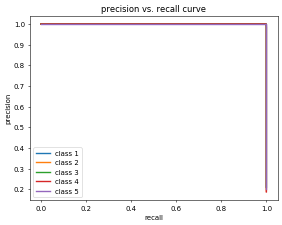

In [41]:
precision_recall_multiclass(RFC, X_test_mixed, y_test_mixed)

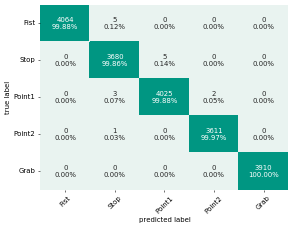

In [42]:
y_pred_mixed = RFC.predict(X_test_mixed)
plot_cm(y_test_mixed, y_pred_mixed)

Too good to be true...<br>
This was a demonstration how we should not split the data set!
Many people on kaggel etc. made this mistake

From now on we will not use this (wrong) processed data set

### b) Custom CV - with raw data

In [43]:
# With custom cross validation

# Create a list of users
user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

# Number of users to be used for the test set
num_user_test = 2
num_of_iterations = 4

best_model = None
best_acc = 0
X_test_best = None
y_test_best = None

for i in range(num_of_iterations):

    print('*'*50)
    print(f'CV Run: {i}')

    # Create the classifier
    RFC_split_raw = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                              max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap,oob_score=oob_score, n_jobs=n_jobs, random_state=random_state)

    X_train_split_raw, y_train_split_raw, X_test_split_raw, y_test_split_raw, user_list = custom_cv_approach(df_raw, user_list, num_user_test=num_user_test)
    
    # Normalize the data
    scaler = MinMaxScaler()
    scaler.fit(X_train_split_raw)
    X_train_split_raw = scaler.transform(X_train_split_raw)
    X_test_split_raw = scaler.transform(X_test_split_raw)
    
    # Fit the model
    RFC_split_raw.fit(X_train_split_raw, y_train_split_raw)
    model_acc = RFC_split_raw.score(X_test_split_raw, y_test_split_raw)

    # Print the results
    print('Train accuracy: ', RFC_split_raw.score(X_train_split_raw, y_train_split_raw))
    print('(CV-) Test accuracy: ', model_acc)

    # Save best model
    if model_acc > best_acc:
        best_model = RFC_split_raw
        best_acc = model_acc
        X_test_best = X_test_split_raw
        y_test_best = y_test_split_raw


**************************************************
CV Run: 0
User picked for test set: 2, 1
train_indices examples: 67994
test_indices examples: 9230
Train accuracy:  1.0
(CV-) Test accuracy:  0.7639219934994583
**************************************************
CV Run: 1
User picked for test set: 5, 8
train_indices examples: 56078
test_indices examples: 11916
Train accuracy:  1.0
(CV-) Test accuracy:  0.6201745552198724
**************************************************
CV Run: 2
User picked for test set: 11, 9
train_indices examples: 44097
test_indices examples: 11981
Train accuracy:  1.0
(CV-) Test accuracy:  0.6060429012603289
**************************************************
CV Run: 3
User picked for test set: 14, 10
train_indices examples: 27029
test_indices examples: 17068
Train accuracy:  1.0
(CV-) Test accuracy:  0.6362198265760487


#### Evaluation

In [44]:
raw_w_cv_data_report = Report(best_model, X_test_best, y_test_best, description=['cv_data', 'raw features'])
print(raw_w_cv_data_report)


        ***********************REPORT*******************************
        Average (macro) precision: 0.75164
        Average accuracy: 0.763922
        Average (macro) recall: 0.745397
        Description cv_data, raw features
        ************************************************************
        


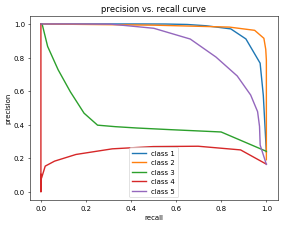

In [45]:
precision_recall_multiclass(RFC_split_raw, X_test_split_raw, y_test_split_raw)

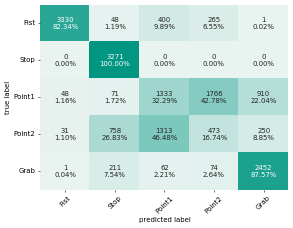

In [46]:
y_pred_split_raw = RFC_split_raw.predict(X_test_split_raw)
plot_cm(y_test_split_raw, y_pred_split_raw)

Here we can see that its difficult for the model to classify the "Fist" and "Point2" data points

### c) Custom CV - with pned features

In [47]:
# From now on we will use the following data
df_aggregate

,X_mean,Y_mean,Z_mean,n_points,eigenvec_1_1,eigenvec_1_2,eigenvec_1_3,eigenvec_2_1,eigenvec_2_2,eigenvec_2_3,eigenvec_3_1,eigenvec_3_2,eigenvec_3_3,eigenval_1,eigenval_2,eigenval_3,User,Class
0,31.220158,27.403799,-33.548944,5.0,-0.592168,-0.526425,0.610093,-0.679408,-0.080937,-0.729283,-0.433292,0.846361,0.309729,3303.459708,31.125729,393.299191,0,1
1,32.392560,27.823996,-32.104566,5.0,-0.612694,-0.533061,0.583483,-0.660054,-0.060910,-0.748745,-0.434667,0.843882,0.314529,3308.347956,26.851403,393.193165,0,1
2,32.081207,27.936918,-32.385520,5.0,-0.606186,-0.535279,0.588231,-0.658320,-0.077302,-0.748758,-0.446266,0.841131,0.305525,3313.095350,27.067267,395.055695,0,1
3,31.719552,27.575915,-32.964177,5.0,-0.600247,-0.529105,0.599793,-0.655695,-0.103896,-0.747843,-0.458004,0.842172,0.284569,3306.145497,27.729013,393.524673,0,1
4,31.594851,27.416170,-33.195235,5.0,-0.598431,-0.526505,0.603881,-0.657469,-0.108005,-0.745701,-0.457837,0.843284,0.281527,3304.675159,29.444009,393.498111,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77219,27.823671,97.288106,-29.054040,10.0,0.875153,-0.440633,-0.199875,-0.449442,-0.893308,0.001453,0.179191,-0.088561,0.979820,2029.730672,761.522468,584.641706,14,5
77220,28.021968,97.191781,-29.248339,10.0,0.869813,-0.446504,-0.209904,-0.461688,-0.886626,-0.027154,0.173982,-0.120529,0.977345,2064.006800,762.311322,588.108972,14,5
77221,28.103645,96.953570,-29.735080,10.0,0.865906,-0.452405,-0.213392,-0.472325,-0.879944,-0.051069,0.164669,-0.145012,0.975631,2074.594214,767.103862,592.169837,14,5
77222,20.384035,93.649845,-25.356364,9.0,0.213676,0.226960,0.950174,-0.815051,0.577614,0.045320,0.538548,0.784124,-0.308407,591.537322,1397.531289,1796.343364,14,5


In [48]:
def cv_ratio(y_test, df):
    print(f'Ratio of test set: {len(y_test)/len(df)}')

In [49]:
# With custom cross validation

# Create a list of users
user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

# Number of users to be used for the test set
num_user_test = 2
num_of_iterations = 4

best_model = None
best_acc = 0
X_test_best = None
y_test_best = None

for i in range(num_of_iterations):

    print('*'*50)
    print(f'CV Run: {i}')

    RFC_cv_extract = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                              max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap,oob_score=oob_score, n_jobs=n_jobs, random_state=random_state)

    # Split the data
    X_train_cv_extract, y_train_cv_extract, X_test_cv_extract, y_test_cv_extract, user_list = custom_cv_approach(df_aggregate, user_list, num_user_test=num_user_test)
    cv_ratio(y_test_cv_extract, df_aggregate)

    # Normalize the data
    scaler = MinMaxScaler()
    scaler.fit(X_train_cv_extract)
    X_train_cv_extract = scaler.transform(X_train_cv_extract)
    X_test_cv_extract = scaler.transform(X_test_cv_extract)

    # Fit the model
    RFC_cv_extract.fit(X_train_cv_extract, y_train_cv_extract)
    model_acc = RFC_cv_extract.score(X_test_cv_extract, y_test_cv_extract)
    
    # Print the results
    print('Train accuracy: ', RFC_cv_extract.score(X_train_cv_extract, y_train_cv_extract))
    print('(CV-) Test accuracy: ', model_acc)

    # Save best model
    if model_acc > best_acc:
        best_model = RFC_cv_extract
        best_acc = model_acc
        X_test_best = X_test_cv_extract
        y_test_best = y_test_cv_extract


**************************************************
CV Run: 0
User picked for test set: 14, 12
train_indices examples: 64864
test_indices examples: 12360
Ratio of test set: 0.16005386926344142
Train accuracy:  1.0
(CV-) Test accuracy:  0.6544498381877023
**************************************************
CV Run: 1
User picked for test set: 9, 2
train_indices examples: 56431
test_indices examples: 8433
Ratio of test set: 0.10920180254843054
Train accuracy:  1.0
(CV-) Test accuracy:  0.7629550575121546
**************************************************
CV Run: 2
User picked for test set: 0, 8
train_indices examples: 40572
test_indices examples: 15859
Ratio of test set: 0.20536361752822957
Train accuracy:  1.0
(CV-) Test accuracy:  0.7074216533198815
**************************************************
CV Run: 3
User picked for test set: 1, 6
train_indices examples: 31478
test_indices examples: 9094
Ratio of test set: 0.11776131772505957
Train accuracy:  1.0
(CV-) Test accuracy:  0.747415878

#### Evaluation

In [50]:
extract_w_cv_data_report = Report(best_model, X_test_best, y_test_best, description=['cv_data', 'extracted features'])
print(extract_w_cv_data_report)


        ***********************REPORT*******************************
        Average (macro) precision: 0.82393
        Average accuracy: 0.762955
        Average (macro) recall: 0.740382
        Description cv_data, extracted features
        ************************************************************
        


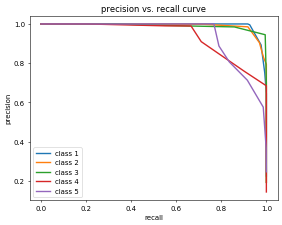

In [51]:
precision_recall_multiclass(best_model, X_test_cv_extract, y_test_cv_extract)

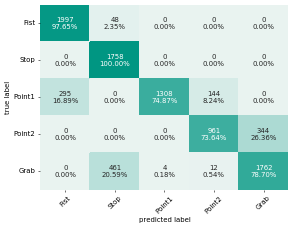

In [52]:
y_pred_cv_extract = best_model.predict(X_test_cv_extract)
plot_cm(y_test_cv_extract, y_pred_cv_extract)

With the extracted features the model improved in predicting "Point2" data points, but the perfomance for predicting "Grab" decreased

## Logistic Regression

In [53]:
# Hyperparameters:
penalty = 'l2'
C = 1.0 #regularization strength. The smaller the value, the stronger the regularization.
random_state = 2023
solver = 'lbfgs' # One of the possible solver for multiclass problems (‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’)
max_iter = 300


### a) Custom CV - with raw data

In [54]:
# With custom cross validation

# Create a list of users
user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

# Number of users to be used for the test set
num_user_test = 2
num_of_iterations = 4

best_model = None
best_acc = 0
X_test_best = None
y_test_best = None

for i in range(num_of_iterations):

    print('*'*50)
    print(f'CV Run: {i}')

    logReg_split_raw = LogisticRegression(penalty=penalty, C=C,random_state=random_state, solver=solver, max_iter=max_iter)

    X_train_split_raw, y_train_split_raw, X_test_split_raw, y_test_split_raw, user_list = custom_cv_approach(df_raw, user_list, num_user_test=num_user_test)
    
    # Scale the data
    scaler = StandardScaler()
    scaler.fit(X_train_split_raw)
    X_train_split_raw = scaler.transform(X_train_split_raw)
    X_test_split_raw = scaler.transform(X_test_split_raw)
    
    # Fit the model
    logReg_split_raw.fit(X_train_split_raw, y_train_split_raw)
    model_acc = logReg_split_raw.score(X_test_split_raw, y_test_split_raw)

    # Print the results
    print('Train accuracy: ', logReg_split_raw.score(X_train_split_raw, y_train_split_raw))
    print('(CV-) Test accuracy: ', model_acc)

    # Save best model
    if model_acc > best_acc:
        best_model = logReg_split_raw
        best_acc = model_acc
        X_test_best = X_test_split_raw
        y_test_best = y_test_split_raw


**************************************************
CV Run: 0
User picked for test set: 5, 2
train_indices examples: 67606
test_indices examples: 9618
Train accuracy:  0.8735023518622608
(CV-) Test accuracy:  0.6093782491162404
**************************************************
CV Run: 1
User picked for test set: 0, 6
train_indices examples: 54181
test_indices examples: 13425
Train accuracy:  0.8924346173012679
(CV-) Test accuracy:  0.7284916201117319
**************************************************
CV Run: 2
User picked for test set: 12, 10
train_indices examples: 39743
test_indices examples: 14438
Train accuracy:  0.9104748005938152
(CV-) Test accuracy:  0.7767696356836127
**************************************************
CV Run: 3
User picked for test set: 11, 9
train_indices examples: 27762
test_indices examples: 11981
Train accuracy:  0.9252935667459117
(CV-) Test accuracy:  0.6971872130873884


Error occured:
ConvergenceWarning: lbfgs failed to converge (status=1)
-> increase max_iter

#### Evaluation

In [55]:
raw_w_cv_data_report_lg = Report(best_model, X_test_best, y_test_best, description=['LogReg', 'cv_data', 'raw features'])
print(raw_w_cv_data_report_lg)


        ***********************REPORT*******************************
        Average (macro) precision: 0.80433
        Average accuracy: 0.77677
        Average (macro) recall: 0.787811
        Description LogReg, cv_data, raw features
        ************************************************************
        


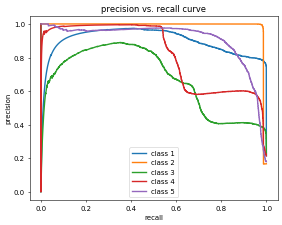

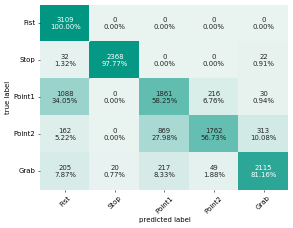

In [56]:
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred)

### b) Custom CV - with extracted features

In [57]:
# With custom cross validation

# Create a list of users
user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

# Number of users to be used for the test set
num_user_test = 2
num_of_iterations = 4

best_model = None
best_acc = 0
X_test_best = None
y_test_best = None

for i in range(num_of_iterations):

    print('*'*50)
    print(f'CV Run: {i}')

    logReg_split_raw = LogisticRegression(penalty=penalty, C=C,random_state=random_state, solver=solver)

    # Split the data
    X_train_cv_extract, y_train_cv_extract, X_test_cv_extract, y_test_cv_extract, user_list = custom_cv_approach(df_aggregate, user_list, num_user_test=num_user_test)
    cv_ratio(y_test_cv_extract, df_aggregate)

    # Normalize the data
    scaler = MinMaxScaler()
    scaler.fit(X_train_cv_extract)
    X_train_cv_extract = scaler.transform(X_train_cv_extract)
    X_test_cv_extract = scaler.transform(X_test_cv_extract)

    # Fit the model
    logReg_split_raw.fit(X_train_cv_extract, y_train_cv_extract)
    model_acc = logReg_split_raw.score(X_test_cv_extract, y_test_cv_extract)
    
    # Print the results
    print('Train accuracy: ', logReg_split_raw.score(X_train_cv_extract, y_train_cv_extract))
    print('(CV-) Test accuracy: ', model_acc)

    # Save best model
    if model_acc > best_acc:
        best_model = logReg_split_raw
        best_acc = model_acc
        X_test_best = X_test_cv_extract
        y_test_best = y_test_cv_extract


**************************************************
CV Run: 0
User picked for test set: 5, 1
train_indices examples: 67402
test_indices examples: 9822
Ratio of test set: 0.12718843882730757


/home/josh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  0.9092311800836771
(CV-) Test accuracy:  0.524231317450621
**************************************************
CV Run: 1
User picked for test set: 10, 11
train_indices examples: 49768
test_indices examples: 17634
Ratio of test set: 0.22834869988604578


/home/josh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  0.9168341102716605
(CV-) Test accuracy:  0.7174208914596801
**************************************************
CV Run: 2
User picked for test set: 8, 12
train_indices examples: 38092
test_indices examples: 11676
Ratio of test set: 0.15119651921682378


/home/josh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:  0.9287251916412895
(CV-) Test accuracy:  0.7091469681397738
**************************************************
CV Run: 3
User picked for test set: 9, 14
train_indices examples: 26677
test_indices examples: 11415
Ratio of test set: 0.1478167409095618
Train accuracy:  0.9382239382239382
(CV-) Test accuracy:  0.6493210687691634


/home/josh/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Evaluation

In [58]:
raw_w_cv_data_report_lg = Report(best_model, X_test_best, y_test_best, description=['LogReg', 'cv_data', 'extracted features'])
print(raw_w_cv_data_report_lg)


        ***********************REPORT*******************************
        Average (macro) precision: 0.7741
        Average accuracy: 0.717421
        Average (macro) recall: 0.705575
        Description LogReg, cv_data, extracted features
        ************************************************************
        


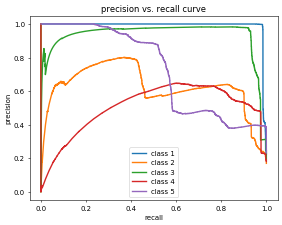

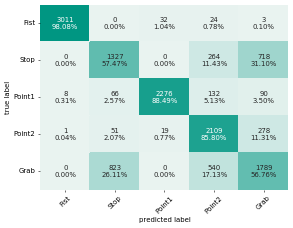

In [92]:
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred)

## Support Vector Machine (SVM)

### a) Custom CV - with raw data

In [93]:
# Hyperparameters:
penalty = 'l2'
C = 1.0 #regularization strength. The smaller the value, the stronger the regularization.
gamma='scale'
kernel = 'rbf'
decision_function_shape = 'ovo'
random_state = 2023
max_iter = -1 # -1 means no limit
cache_size = 200 # in MB
probabilty = True # needed for predict_proba later on


In [94]:
# With custom cross validation

# Create a list of users
user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

# Number of users to be used for the test set
num_user_test = 2
num_of_iterations = 4

best_model = None
best_acc = 0
X_test_best = None
y_test_best = None

for i in range(num_of_iterations):

    print('*'*50)
    print(f'CV Run: {i}')

    svm_model_split_raw = SVC(decision_function_shape=decision_function_shape, kernel=kernel, C=C, gamma=gamma, max_iter=max_iter, cache_size=200, probability=probabilty)

    X_train_split_raw, y_train_split_raw, X_test_split_raw, y_test_split_raw, user_list = custom_cv_approach(df_raw, user_list, num_user_test=num_user_test)
    
    # Scale the data
    scaler = StandardScaler()
    scaler.fit(X_train_split_raw)
    X_train_split_raw = scaler.transform(X_train_split_raw)
    X_test_split_raw = scaler.transform(X_test_split_raw)
    
    # Fit the model
    svm_model_split_raw.fit(X_train_split_raw, y_train_split_raw)
    model_acc = svm_model_split_raw.score(X_test_split_raw, y_test_split_raw)

    # Print the results
    print('Train accuracy: ', svm_model_split_raw.score(X_train_split_raw, y_train_split_raw))
    print('(CV-) Test accuracy: ', model_acc)

    # Save best model
    if model_acc > best_acc:
        best_model = svm_model_split_raw
        best_acc = model_acc
        X_test_best = X_test_split_raw
        y_test_best = y_test_split_raw

    


**************************************************
CV Run: 0
User picked for test set: 2, 11
train_indices examples: 64650
test_indices examples: 12574
Train accuracy:  0.9966125290023202
(CV-) Test accuracy:  0.6895975823127087
**************************************************
CV Run: 1
User picked for test set: 0, 8
train_indices examples: 48791
test_indices examples: 15859
Train accuracy:  0.9969461581029289
(CV-) Test accuracy:  0.7170061164007819
**************************************************
CV Run: 2
User picked for test set: 5, 1
train_indices examples: 38969
test_indices examples: 9822
Train accuracy:  0.9967923221021838
(CV-) Test accuracy:  0.44502138057422114
**************************************************
CV Run: 3
User picked for test set: 13, 9
train_indices examples: 26310
test_indices examples: 12659
Train accuracy:  0.9955150133029267
(CV-) Test accuracy:  0.8802433051583853


#### Evaluation

In [95]:
raw_w_cv_data_report_svm = Report(best_model, X_test_best, y_test_best, description=['SVM', 'cv_data', 'raw features'])
print(raw_w_cv_data_report_svm)


        ***********************REPORT*******************************
        Average (macro) precision: 0.89292
        Average accuracy: 0.880243
        Average (macro) recall: 0.880283
        Description SVM, cv_data, raw features
        ************************************************************
        


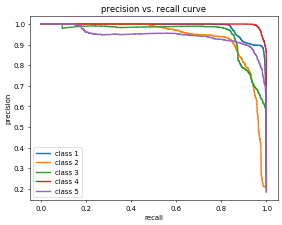

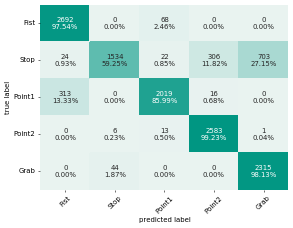

In [96]:
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred)

### b) Custom CV - with extracted features

In [97]:
# With custom cross validation

# Create a list of users
user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

# Number of users to be used for the test set
num_user_test = 2
num_of_iterations = 4

best_model = None
best_acc = 0
X_test_best = None
y_test_best = None

for i in range(num_of_iterations):

    print('*'*50)
    print(f'CV Run: {i}')

    svm_model_split_extract = SVC(decision_function_shape=decision_function_shape, kernel=kernel, C=C, gamma=gamma, max_iter=max_iter, cache_size=200, probability=probabilty)

    # Split the data
    X_train_cv_extract, y_train_cv_extract, X_test_cv_extract, y_test_cv_extract, user_list = custom_cv_approach(df_aggregate, user_list, num_user_test=num_user_test)
    cv_ratio(y_test_cv_extract, df_aggregate)

    # Normalize the data
    scaler = MinMaxScaler()
    scaler.fit(X_train_cv_extract)
    X_train_cv_extract = scaler.transform(X_train_cv_extract)
    X_test_cv_extract = scaler.transform(X_test_cv_extract)

    # Fit the model
    svm_model_split_extract.fit(X_train_cv_extract, y_train_cv_extract)
    model_acc = svm_model_split_extract.score(X_test_cv_extract, y_test_cv_extract)
    
    # Print the results
    print('Train accuracy: ', svm_model_split_extract.score(X_train_cv_extract, y_train_cv_extract))
    print('(CV-) Test accuracy: ', model_acc)

    # Save best model
    if model_acc > best_acc:
        best_model = svm_model_split_extract
        best_acc = model_acc
        X_test_best = X_test_cv_extract
        y_test_best = y_test_cv_extract


**************************************************
CV Run: 0
User picked for test set: 2, 5
train_indices examples: 67606
test_indices examples: 9618
Ratio of test set: 0.12454677302393038
Train accuracy:  0.9953110670650533
(CV-) Test accuracy:  0.6889166146808068
**************************************************
CV Run: 1
User picked for test set: 9, 12
train_indices examples: 58821
test_indices examples: 8785
Ratio of test set: 0.11375997099347353
Train accuracy:  0.9951037894629469
(CV-) Test accuracy:  0.7723392145702903
**************************************************
CV Run: 2
User picked for test set: 8, 10
train_indices examples: 42437
test_indices examples: 16384
Ratio of test set: 0.2121620221692738
Train accuracy:  0.9938497066239367
(CV-) Test accuracy:  0.79107666015625
**************************************************
CV Run: 3
User picked for test set: 14, 11
train_indices examples: 26881
test_indices examples: 15556
Ratio of test set: 0.20143996684968404
Train accu

#### Evaluation

In [98]:
extract_w_cv_data_report_svm = Report(best_model, X_test_best, y_test_best, description=['SVM', 'cv_data', 'extracted features'])
print(extract_w_cv_data_report_svm)


        ***********************REPORT*******************************
        Average (macro) precision: 0.81809
        Average accuracy: 0.791077
        Average (macro) recall: 0.798642
        Description SVM, cv_data, extracted features
        ************************************************************
        


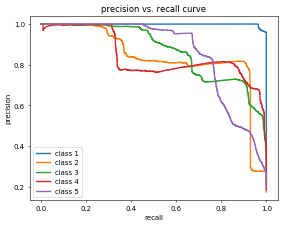

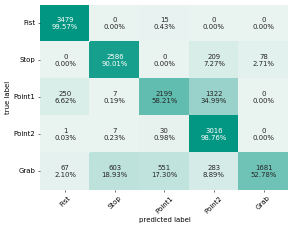

In [99]:
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred)

TODO other models to try <br>
LightGBM

In [100]:
#TODO boxplot of the results
'''
ax = sns.boxplot(data = f2_df, linewidth=1, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sns.set(rc = {'figure.figsize':(8,10)})
ax.set(ylabel='F2-Score')
ax.set_title('F2-Score Deviation of different Models')
'''

"\nax = sns.boxplot(data = f2_df, linewidth=1, showfliers=False)\nax.set_xticklabels(ax.get_xticklabels(),rotation=90)\nsns.set(rc = {'figure.figsize':(8,10)})\nax.set(ylabel='F2-Score')\nax.set_title('F2-Score Deviation of different Models')\n"

## Conclusion Testing Phase I

TODO

Extracted features?
* good, we see an improvement ...

Confusion Matrix:
* what cases are difficult
* which are easy
* explanation why

Feature reduction
* good/bad
* PCA
* which models got worses

Best model:
* e.g. rf with extracted data

# 4. Testing Phase II: Model Develepoment

## Base MLP structure

* Activation Functions
    - output layer: one neuron for each class (5)
    - we want the the probability of the each class, -> **softmax**
    - hidden Layer: start with **ReLU**

* Optimizer
    - **rmsprop**

* loss
    - **categorical_crossentropy**

* Hidden Layers and Number of Neurons
    - start with small architecture, increase size

* Metric
    - **accuracy**
    - **precission**


In [101]:
# Hyperparameters
#TODO set number of epochs to 15
#TODO 45 per k fold (4 folds) will take 5 hours
hyperparams = {'num_epochs': 40,
               'batch_size':10,
               'hidden_layer':2,
               'units_hidden_layer': 32,
               'activation_hidden': 'relu',
               'activation_output': 'softmax',
               'loss': 'categorical_crossentropy',
               'metric_1': 'categorical_accuracy',
               'metric_2': 'Precision',
               'optimizer': keras.optimizers.legacy.Adam(),
               'initialization': '-',
               'weight regularisation l2': '-',
               'dropout': '-',  # typically between 0.3 and 0.5 (half of weights get 0)
               'early Stopping': 'False'} 

In [102]:
from tensorflow import keras
from tensorflow.keras import layers


def build_mlp_model(name:str, hyperparams:dict, input_shape: tuple, output_shape: int) -> keras.Sequential:
    'Build MLP classification network'

    model = keras.Sequential(name=name)
    model.add(keras.Input(shape=input_shape))
    model.add(layers.Dense(32, activation='relu'))
    #model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation='relu'))
    #model.add(layers.BatchNormalization())
    model.add(layers.Dense(16, activation='relu'))
    #model.add(layers.BatchNormalization())
    model.add(layers.Dense(output_shape, activation='softmax'))

    model.compile(optimizer=hyperparams['optimizer'], loss=hyperparams['loss'], metrics=[hyperparams['metric_1'], hyperparams['metric_2']])

    return model

In [103]:
def plot_learning_curves(history, parameters, name:str):
    #TODO: modify
    
    plt.plot(history['epoch'][:],history['loss'][:], "k--", linewidth=1.5, label="Training")
    plt.plot(history['epoch'][:],history['val_loss'][:], "b-.", linewidth=1.5, label="CV test")
    plt.legend()
    plt.ylim(0,max(history['loss'][:], history['val_loss'][:])+0.2)
    plt.xlabel("Epochs"),  plt.ylabel("categorical_crossentropy")

    plt.title(f'Learning Curve: {name}', fontsize=18)
    plt.show()

In [104]:
def list_used_parameters(parameters:dict):
    print('Used parameters:')
    for parameter, value in parameters.items():
        print(f'{parameter}: {value}')

In [105]:
def decode_one_hot(one_hot_encoded):
    return np.argmax(one_hot_encoded)

In [106]:
def train_k_mlp_model(name, df:pd.DataFrame, hyperparams:dict):
    '''
    Train a MLP model with k-fold cross validation (leave n users out strategy)

    Parameters
    ----------
    name : str, Name of the model.

    Returns
    ----------
    best_model : keras.Sequential, The best model.
    best_acc : float, The best accuracy.
    X_test_best : numpy.ndarray, The best test set.
    y_test_best : numpy.ndarray, The best test set.
    '''
    

    # Create a list of users
    user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

    # Number of users to be used for the test set
    num_user_test = 2
    num_of_iterations = 4

    best_model = None
    best_acc = 0
    X_test_best = None
    y_test_best = None

    all_acc_val = []
    all_prec_val = []

    describe_model = True

    for i in range(num_of_iterations):

        print('*'*50)
        print(f'CV Run: {i}')

        # Split the data
        X_train_cv_extract, y_train_cv_extract, X_test_cv_extract, y_test_cv_extract, user_list = custom_cv_approach(df, user_list, num_user_test=num_user_test)
        cv_ratio(y_test_cv_extract, df)

        # Normalize the data
        scaler = MinMaxScaler()
        scaler.fit(X_train_cv_extract)
        X_train_cv_extract = scaler.transform(X_train_cv_extract)
        X_test_cv_extract = scaler.transform(X_test_cv_extract)
        # y label to one hot encode
        y_train_cv_extract = to_categorical(y_train_cv_extract)
        y_test_cv_extract = to_categorical(y_test_cv_extract)

        # Build the model
        # TODO
        mlp_model = build_mlp_model(name, hyperparams, input_shape=X_train_cv_extract.shape[1:], output_shape=y_train_cv_extract.shape[1])

        # Only print the model summary once
        if describe_model:
            mlp_model.summary()
            describe_model = False

        # Create callback
        early_stop_callback = keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", min_delta=1e-4, patience=5, verbose=1)
        checkpoint_callback = keras.callbacks.ModelCheckpoint(f'model/single_run/{name}_cv{i}.h5', save_best_only=True)

        # Train the model
        history = mlp_model.fit(X_train_cv_extract, 
                                y_train_cv_extract, 
                                epochs=hyperparams['num_epochs'], 
                                batch_size= hyperparams['batch_size'],
                                validation_data=(X_test_cv_extract, y_test_cv_extract),
                                verbose=1,
                                shuffle=True,
                                callbacks=[early_stop_callback, checkpoint_callback])

        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch

        #Evaluating the training performance:
        train_loss, train_acc, train_precision = mlp_model.evaluate(x=X_train_cv_extract, y=y_train_cv_extract, batch_size=hyperparams['batch_size'], verbose=3)
        print('-'*70)
        print('Evaluation of training Data: \n', 'training loss: ', train_loss, 'training accuracy: ', train_acc)

        #Evaluating the CV pperformance:
        val_loss, val_acc, val_precision = mlp_model.evaluate(x=X_test_cv_extract, y=y_test_cv_extract, batch_size=hyperparams['batch_size'], verbose=0)
        all_acc_val.append(val_acc)
        all_prec_val.append(val_precision)
        print('Evaluation of validation Data: \n', 'cv loss: ', val_loss, 'cv accuracy: ', val_acc)

        # Save best model
        if model_acc > best_acc:
            best_model = mlp_model
            best_acc = model_acc
            X_test_best = X_test_cv_extract
            y_test_best = y_test_cv_extract

    #Lets see the overall score as average of the scores of all the folds:
    print('-'*70)
    print('(all CV runs combined)')
    print('Mean Accuracy  for the validation dataset: ', np.mean(all_acc_val))
    print('Mean Precision for the validation dataset: ', np.mean(all_prec_val))
    print('-'*70)

    # Save the model
    best_model.save(f'model/single_run/{name}_best_model.h5')

    # Plot the learning curves
    plot_learning_curves(hist, hyperparams, name)

    return best_model, best_acc, X_test_best, y_test_best


### a) Custom CV - with raw data

To get an Idea How long the model trains: <br>
13 min 30 sec for 4 runs
* each trains for 2 epochs

Highly depends on the used Hardware! <br>
Here we use an M1 macbook with GPU tf vesion

In [107]:
name = 'mlp_base_model_raw'
df = df_raw
best_model, best_acc, X_test_best, y_test_best = train_k_mlp_model(name, df, hyperparams)

**************************************************
CV Run: 0
User picked for test set: 14, 11
train_indices examples: 61668
test_indices examples: 15556
Ratio of test set: 0.20143996684968404


2023-03-04 11:35:30.084649: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/josh/Documents/seam_eng/group4_ws/devel/lib:/opt/ros/noetic/lib
2023-03-04 11:35:30.094114: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-04 11:35:30.094163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (josh): /proc/driver/nvidia/version does not exist
2023-03-04 11:35:30.114395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compile

Model: "mlp_base_model_raw"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1024      
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 6)                 102       
                                                                 
Total params: 4,278
Trainable params: 4,278
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
6167/6167 [==============================] - 12s 2ms/step - loss: 0.6395 - categorical_accuracy: 0.7394 - precision: 0.7990 - val_loss: 0.7228 - val_categorical_accura

In [ ]:
data_report_mlp_base_raw = Report(best_model, X_test_best, y_test_best, description=['MLP base', 'cv_data', 'raw features'])
print(data_report_mlp_base_raw)

AttributeError: 'Sequential' object has no attribute 'predict_proba'

In [ ]:
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred)

### b) Custom CV - with extracted features

#### Training

In [ ]:
name = 'mlp_base_model_extracted'
df = df_aggregate
best_model, best_acc, X_test_best, y_test_best = train_k_mlp_model(name, df, hyperparams)

#### Evaluation

In [ ]:
data_report_mlp_base_extracted = Report(best_model, X_test_best, y_test_best, description=['MLP base', 'cv_data', 'extracted features'])
print(data_report_mlp_base_extracted)

AttributeError: 'NoneType' object has no attribute 'predict_proba'

In [ ]:
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred)

## PointNet

Note: for this archtitecture we have to use the original, raw data because we need a Point Cloud!

From the Paper: "PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation" (Charles R. Qi et al)
https://arxiv.org/abs/1612.00593

DISCLAIMER:
Implementation with Keras:<br>
https://keras.io/examples/vision/pointnet/

Here we replicate the network architecture published in the original paper with the help of this blogpost!

General
* Point cloud =  a geometric data structure with irregular format
* paper proposes a novel neural network called PointNet
* PointNet: directly consumes point clouds + respects the permutation invariance of points in the input
* unified architecture for object classification, part segmentation, and scene semantic parsing
* simple, efficient, and effective

Architecture
* deal with unordered input set: use of a single symmetric function, max pooling
* network learns a set of optimization functions/criteria that select interesting or informative points of the point cloud and encode the reason for their selection
* final fully connected layers: aggregate these learnt optimal values into the global descriptor for the entire shape (shape classification) or are used to predict per point labels (shape segmentation).

Each convolution and fully-connected layer (with exception for end layers) consits of 
* Convolution / Dense
* Batch Normalization
* ReLU Activation.

In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

PointNet consists of two core components
* primary MLP network
* transformer net (T-net)
    * aims to learn an affine transformation matrix by its own mini network
    * used twice:
        * 1.to transform the input features (n, 3) into a canonical representation
        * 2.affine transformation for alignment in feature space (n, 3)

What will we do?
* implement main network 
* drop the t-net mini models as layers in the graph

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [ ]:
def tnet(inputs, num_features):
    '''Build T-net layers'''
    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [ ]:
def build_pointnet(num_points, num_classes):
    '''Use the functional API to build a PointNet model (different from the Sequential API)'''
    inputs = keras.Input(shape=(num_points, 3))

    x = tnet(inputs, 3)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = tnet(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = layers.Dropout(0.3)(x)
    x = dense_bn(x, 128)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
    model.summary()

    return model

Now we have all utility functions we need for our PointNet model<br>
We have to preprocess the input data to be compatible with the network

In [ ]:
def custom_cv_approach_point_clouds(np_batches:np.array, df:pd.DataFrame, user_list:list, num_user_test:int=2) -> Tuple[np.array, np.array, np.array, np.array, list]:
    '''
    MODIFIED for point cloud data
    each user is iteratively left out from training and used as a test set. 
    We then tests the generalization of the algorithm to new users. 
    A 'User' attribute is provided to accomodate this strategy. 
    '''
    
    # Get the indices for the training and test set
    train_indices, test_indices, user_list = get_train_test_user(df, user_list, num_user_test)
    print(f'train_indices examples: {len(train_indices)}')
    print(f'test_indices examples: {len(test_indices)}')
    # Create the training and test set
    # MODIFIED for point cloud data
    X_train = np_batches[train_indices, :, :]
    y_train = df.iloc[train_indices, :]['Class']
    X_test = np_batches[test_indices, :, :]
    y_test = df.iloc[test_indices, :]['Class']

    return X_train, y_train, X_test, y_test, user_list

In [ ]:
def train_k_pn_model(name, np_batches:np.array, df:pd.DataFrame, hyperparams:dict):
    '''
    Train multiple PointNet models with k-fold cross validation (leave n users out strategy)

    Parameters
    ----------
    name : str, Name of the model.
    np_batches : numpy.ndarray, The data.
    df : pandas.DataFrame, We will use this dataframe ONLY to get the labels.
    hyperparams : dict, The hyperparameters.

    Returns
    ----------
    best_model : keras.Sequential, The best model.
    best_acc : float, The best accuracy.
    X_test_best : numpy.ndarray, X_test set
    y_test_best : numpy.ndarray, y_test set
    '''
    

    # Create a list of users
    user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

    # Number of users to be used for the test set
    num_user_test = 2
    num_of_iterations = 4

    best_model = None
    best_acc = 0
    X_test_best = None
    y_test_best = None

    all_acc_val = []
    all_prec_val = []

    describe_model = True

    for i in range(num_of_iterations):

        print('*'*50)
        print(f'CV Run: {i}')

        # Split the data into train and test set
        X_train_cv_pn, y_train_cv_pn, X_test_cv_pn, y_test_cv_pn, user_list = custom_cv_approach_point_clouds(np_batches, df_raw, user_list, num_user_test=num_user_test)
        cv_ratio(y_test_cv_pn, df_raw)

        # Normalize the data
        scaler = MinMaxScaler()
        X_train_cv_pn = scaler.fit_transform(X_train_cv_pn.reshape(-1, X_train_cv_pn.shape[-1])).reshape(X_train_cv_pn.shape)
        X_test_cv_pn = scaler.transform(X_test_cv_pn.reshape(-1, X_test_cv_pn.shape[-1])).reshape(X_test_cv_pn.shape)
        # y label to one hot encode
        y_train_cv_pn = to_categorical(y_train_cv_pn)
        y_test_cv_pn = to_categorical(y_test_cv_pn)

        # Build model
        print('X_train.shape: ', X_train_cv_pn.shape)
        print('Sample input shape: ', X_train_cv_pn[0].shape)
        print('Sample input: ', X_train_cv_pn[0])
        print('y_train.shape: ', y_train_cv_pn.shape)
        
        max_num_points = 10
        #TODO add hyperparams
        pointnet_model = build_pointnet(max_num_points, y_train_cv_pn.shape[1])

        # Only print the model summary once
        if describe_model:
            pointnet_model.summary()
            describe_model = False

        # Create callback
        early_stop_callback = keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", min_delta=1e-4, patience=5, verbose=1)
        checkpoint_callback = keras.callbacks.ModelCheckpoint(f'model/single_run/{name}_cv{i}.h5', save_best_only=True)
        
        pointnet_model.compile(
            loss=hyperparams['loss'],
            optimizer=hyperparams['optimizer'],
            metrics=hyperparams['metrics'],
            )

        # Train the model
        history = pointnet_model.fit(X_train_cv_pn, 
                                y_train_cv_pn, 
                                epochs=hyperparams['num_epochs'], 
                                batch_size= hyperparams['batch_size'],
                                validation_data=(X_test_cv_pn, y_test_cv_pn),
                                verbose=1,
                                shuffle=True,
                                callbacks=[early_stop_callback, checkpoint_callback])

        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch

        #Evaluating the training performance:
        train_loss, train_acc, train_precision = pointnet_model.evaluate(x=X_train_cv_pn, y=y_train_cv_pn, batch_size=hyperparams['batch_size'], verbose=1)
        print('-'*70)
        print('Evaluation of training Data: \n', 'training loss: ', train_loss, 'training accuracy: ', train_acc)

        #Evaluating the CV pperformance:
        val_loss, val_acc, val_precision = pointnet_model.evaluate(x=X_test_cv_pn, y=y_test_cv_pn, batch_size=hyperparams['batch_size'], verbose=1)
        all_acc_val.append(val_acc)
        all_prec_val.append(val_precision)
        print('Evaluation of validation Data: \n', 'cv loss: ', val_loss, 'cv accuracy: ', val_acc)

        # Save best model
        if model_acc > best_acc:
            best_model = pointnet_model
            best_acc = model_acc
            X_test_best = X_test_cv_extract
            y_test_best = y_test_cv_extract

    #Lets see the overall score as average of the scores of all the folds:
    print('-'*70)
    print('(all CV runs combined)')
    print('Mean Accuracy  for the validation dataset: ', np.mean(all_acc_val))
    print('Mean Precision for the validation dataset: ', np.mean(all_prec_val))
    print('-'*70)

    # Save the model
    best_model.save(f'model/single_run/{name}_best_model.h5')

    # Plot the learning curves
    plot_learning_curves(hist, hyperparams, name)

    return best_model, best_acc, X_test_best, y_test_best


In [ ]:
# Each row of data (multiple data points) got stored as single dataframe where each row is one single data point
# Convert the dataframe to 3D numpy Matrix 
np_batches = np.array(list(map(pd.DataFrame.to_numpy, concat_batches)))
np_batches.shape

(77224, 10, 3)

In [ ]:
# We need to reshape the data to be able to normalize it
# EXAMPLE: for 2 batches (for the real data we will do it in the training loop)
print(np_batches[0:2].shape)
reshaped = np_batches[0:2].reshape(-1, np_batches[0].shape[-1])
print(reshaped.shape)

(2, 10, 3)
(20, 3)


In [ ]:
# Hyperparameters
#TODO set number of epochs to 15
# TODO have a look what "sparse_categorical_crossentropy" is
hyperparams = {'num_epochs': 2,
               'batch_size':10,
               'hidden_layer':2,
               'units_hidden_layer': 32,
               'activation_hidden': 'relu',
               'activation_output': 'softmax',
               'loss': 'categorical_crossentropy',
               'metrics': ['categorical_accuracy'],
               'optimizer': keras.optimizers.legacy.Adam(learning_rate=0.001),
               'initialization': '-',
               'weight regularisation l2': '-',
               'dropout': '-',  # typically between 0.3 and 0.5 (half of weights get 0)
               'early Stopping': 'False'} 

In [ ]:
#TODO have a look what is point 0 X0, Y0

In [ ]:
# Run the model
best_model, best_acc, X_test_best, y_test_best = train_k_pn_model('pointnet_base', np_batches, df_raw, hyperparams)

**************************************************
CV Run: 0
User picked for test set: 6, 14
train_indices examples: 65352
test_indices examples: 11872
Ratio of test set: 0.15373459028281364
X_train.shape:  (65352, 10, 3)
Sample input shape:  (10, 3)
Sample input:  [[0.56377253 0.63563446 0.31622418]
 [0.6364967  0.52860708 0.28725514]
 [0.5070802  0.67332387 0.35942043]
 [0.66328536 0.62191647 0.28397199]
 [0.57959739 0.41132398 0.29264271]
 [0.3894027  0.37191812 0.5517009 ]
 [0.3894027  0.37191812 0.5517009 ]
 [0.3894027  0.37191812 0.5517009 ]
 [0.3894027  0.37191812 0.5517009 ]
 [0.3894027  0.37191812 0.5517009 ]]
y_train.shape:  (65352, 6)
Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 10, 3)]      0           []                               
                               

2023-03-03 14:04:05.393826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 971/6536 [===>..........................] - ETA: 5:47 - loss: 1.0977 - categorical_accuracy: 0.7775

KeyboardInterrupt: 

# 5. Testing Phase III: Model Regularization and Hyperparameter optimization

This section is reserved for neural networks, Fine tune models
regularization
make notes of the trials
save plots
use CV to optimize the model
Add a brief description of this optimization process

number of neurons
regularization
number layers
dropout
Initialization
Optimizer
Batch Size
Epochs

## MLP

## PointNet

# 6. Evaluation of the model predictions

###  All Models/Overall Comparison

# 7. Lessons Learnt and Conclusions

tell us what you found and what you learned!

Logistic Regression
https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Gradient Descent

Random Forests

Boosting (LightGBM)
https://lightgbm.readthedocs.io/en/latest/

## Model 1


### Training

### Evaluation

Confusion Matrix
PR Curve
ROC Curve

### Discussion

## Model 2


### Training

### Evaluation

### Discussion